<a href="https://colab.research.google.com/github/ada-mb2125/DL_exercises/blob/main/Day07-VAEs/Day07-VAEs_afternoon_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/thumbnail?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff&sz=w1500" width="500"/>

---

# **Variational AutoEncoders (VAEs)**

#### **Morning contents/agenda**

1. AutoEncoders

2. Variational AutoEncoders

3. Other VAE architectures

4. A simple VAE demo

#### **Learning outcomes**

1. Understand how Autoencoders can be used for data dimensionality reduction

2. Gain intuition about what a latent space is and how the latent space of Autoencoders and VAEs differ

3. Understand how the reparametrization trick makes VAEs trainable

4. Differentiate the role of the KL Divergence and reconstruction fidelity terms in the loss function of VAEs

<br>

#### **Afternoon contents/agenda**

1. Load the FashionMNIST dataset

2. Implement a convolutional VAE

3. Implement a conditioned convolutional VAE

#### **Learning outcomes**

1. Practice implementation VAEs

2. Understand how to refactor a linear VAE into a convolutional VAE

3. Learn how to perform class-conditioned generation

<br/>

---

<br/>

### **Conditional VAEs**

There is one type of VAE that is of special interest in generative problems: **Conditional Variational AutoEncoders (cVAEs)**.

We have been looking at how VAEs can learn latent representations of a dataset, which can then be used to generate new, original data points. However, what happens if we want to constrain the decoder to produce examples within a certain category?

cVAEs address this by introducing an additional conditional input $c$ to both the encoder and the decoder:

<br>

<center>
<img src="https://drive.google.com/thumbnail?id=1CuNqPhxOCkkwTN7HtIInKo7o3JsppUic&sz=w1500" width="600"/>
</center>

<br>

At generation time, we may simply pass a class of our choosing along with the random vector, and condition our generation.

In this afternoon practical we will look at how to implement these conditional VAEs in PyTorch.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import random
from tqdm import tqdm

from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.model_selection import StratifiedShuffleSplit

from IPython.display import clear_output

In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1. Loading and Visualising the Data

Tasks


- Define a preprocessing transform using `transforms.ToTensor()` so that images are converted to `PyTorch` tensors in the `[0, 1]` range.

- Download and load the training split of `FashionMNIST` from `torchvision.datasets`, applying your transform.

- Use `StratifiedShuffleSplit` to create an `80/20` stratified split of the dataset indices, using the class labels to preserve class balance between training and validation sets.

- Construct `torch.utils.data.Subset` objects for the training and validation subsets, and wrap each one in a `DataLoader` with `batch_size=128`.

- Draw a batch from the training dataloader and select the first 32 images to plot

In [3]:
# preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load dataset
dataset = FashionMNIST(root='data', train=True, transform=transform, download=True)

# Split dataset into train and validation sets
stratified_split = StratifiedShuffleSplit(train_size=0.8, test_size=0.2)
train_idxs, valid_idxs = list(stratified_split.split(dataset.data, dataset.targets))[0]
train_dataset = torch.utils.data.Subset(dataset, train_idxs)
valid_dataset = torch.utils.data.Subset(dataset, valid_idxs)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=0)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.7MB/s]


In [4]:
def plot_batch(batch, nrow=8, title="", ax=None):
    """Plot a batch of images in a grid format."""
    ncol = batch.size(0) // nrow
    grid = make_grid(batch, nrow=nrow).permute(1, 2, 0)
    if ax is None:
        _, ax = plt.subplots(figsize=(2*nrow, 2*ncol))
    ax.imshow(grid.cpu())
    ax.axis('off')
    if title:
        ax.set_title(title)
    if ax is None:
        plt.show()

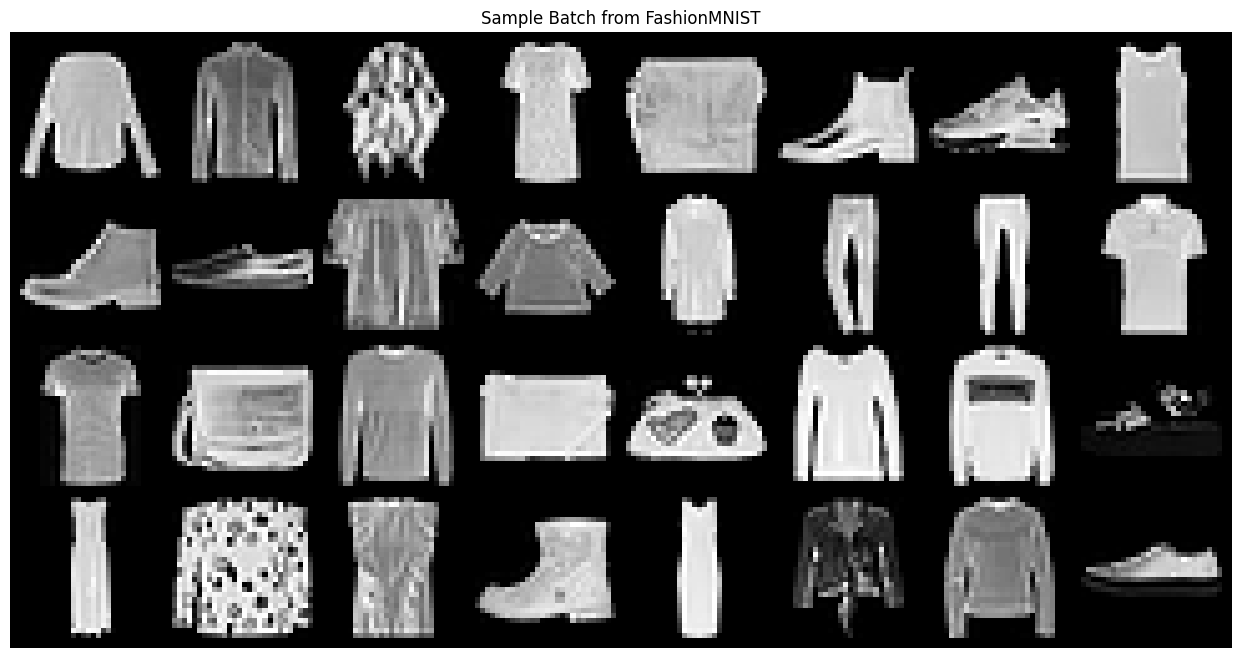

In [5]:
batch = next(iter(train_loader))[0][:32]
plot_batch(batch, nrow=8, title="Sample Batch from FashionMNIST")

## 2. Training Helper Functions


Write the `train` and `validation` functions that will handle optimisation of your VAE. They follow the same structure we used in class, but try to re-write them yourself rather than copying and pasting. This is a good chance to check that you really understand what each step in the training loop is doing, from computing the loss to updating the weights and keeping track of performance. Can you write the `ELBO` loss as its own ``nn.Module`` class?

In [6]:
class ELBO(nn.Module):
  def __init__(self, beta: float = 1.0):
    super(ELBO, self).__init__()
    self.beta = beta

  def forward(self, recon: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    # Reconstruction loss (mean squared error)
    # reduction='sum' sums over the batch
    MSE = torch.nn.functional.mse_loss(recon, x, reduction='sum')
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return self.beta * KLD + MSE

In [7]:
def train(model, train_loader, criterion, optimizer, device):
  model.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon, mu, logvar = model(data)
    loss = criterion(recon, data, mu, logvar)

    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  avg_loss = train_loss / len(train_loader.dataset)
  return avg_loss


In [8]:
def validate(model, val_loader, criterion, device):
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for data, _ in val_loader:
      data = data.to(device)
      recon, mu, logvar = model(data)
      loss = criterion(recon, data, mu, logvar)
      val_loss += loss.item()

  avg_loss = val_loss / len(val_loader.dataset)
  return avg_loss

## 3. Convolutional VAE
Now let's refactor our linear VAE into a convolutional VAE. Like in class, you will build an encoder, a decoder, and a VAE wrapper, and then check that the tensor shapes line up correctly.

Tasks
- Implement a `ConvEncoder` that:
    - Takes `input_channels` and `latent_size` as arguments.

    - Uses a `nn.Sequential` of convolution → batch norm → GELU → max-pooling blocks to map an input image to a compact feature map. Use three blocks with channel sizes 20 → 40 → 60, kernel size 3, appropriate padding to preserve the shape, and `MaxPool2d(2)` to downsample from 32\times32 to 4\times4.

    - Flattens the final feature map (of size 60\times4\times4) and passes it through two linear layers to output `mu` and `logvar`, each of dimension `latent_size`.

- Implement a ``ConvDecoder`` that:
    - First maps a latent vector of size latent_size back to a flattened feature map using a linear layer, then reshapes it to (60, 4, 4), padding it with 3 so that the effective input size is 32x32

    - Uses a `nn.Sequential` of convolution → batch norm → GELU → nearest-neighbour upsampling blocks to progressively upsample back to the image resolution. Mirror the encoder with channel sizes 60 → 60 → 40 → 20 → `input_channels`, and use `Upsample(scale_factor=2, mode="nearest")` between blocks. If you wish, you can also write your decoder with `ConvTranspose2d`

    - Ends with a Sigmoid activation to produce outputs in [0, 1], and crops the borders so the final output has the same spatial size as the original input.

- Implement a `ConvVAE` that:
    - Composes the `ConvEncoder` and `ConvDecoder` in the initialisation.
    - Includes a `sample(mu, logvar)` function that applies the reparameterisation trick $z = \mu + \epsilon\, \sigma$ with $\epsilon \sim \mathcal{N}(0, I)$.
    - In `forward(x)`, encodes x to `mu`, `logvar`, samples `z`, and returns the reconstructed image together with `mu` and `logvar`.

- Test your implementation by:
    - Instantiating ConvEncoder, ConvDecoder, and ConvVAE with input_channels=1 and latent_size=128.

    - Passing a mini-batch from your FashionMNIST dataloader through each component and printing the output shapes to confirm they match the expected dimensions.

In [9]:
class ConvEncoder(nn.Module):
  def __init__(self, input_channels, latent_size):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(input_channels, 20, kernel_size=3, padding=3),
        nn.BatchNorm2d(20),
        nn.GELU(),
        nn.MaxPool2d(2),

        nn.Conv2d(20, 40, kernel_size=3, padding="same"),
        nn.BatchNorm2d(40),
        nn.GELU(),
        nn.MaxPool2d(2), # 16x16 -> 8x8

        nn.Conv2d(40, 60, kernel_size=3, padding="same"),
        nn.BatchNorm2d(60),
        nn.GELU(),
        nn.MaxPool2d(2), # 8x8 -> 4x4
    )
    self.flatten_dim = 60 * 4 * 4
    self.mu_layer = nn.Linear(self.flatten_dim, latent_size)
    self.logvar_layer = nn.Linear(self.flatten_dim, latent_size)

  def forward(self, x):
    x = self.encoder(x).view(-1, self.flatten_dim)
    mu = self.mu_layer(x)
    logvar = self.logvar_layer(x)
    return mu, logvar

In [10]:
conv_encoder = ConvEncoder(input_channels=1, latent_size=32).to(device)
mu, logvar = conv_encoder(batch.to(device))
mu.shape, logvar.shape

(torch.Size([32, 32]), torch.Size([32, 32]))

In [11]:
class ConvDecoder(nn.Module):
  def __init__(self, input_channels, latent_size):
    super().__init__()
    self.proj = nn.Linear(latent_size, 60 * 4 * 4)
    self.decoder = nn.Sequential(
      nn.Conv2d(60, 60, 1),
      nn.BatchNorm2d(60),
      nn.GELU(),
      nn.Upsample(scale_factor=2, mode="nearest"),

      nn.Conv2d(60, 40, 3, padding="same"),
      nn.BatchNorm2d(40),
      nn.GELU(),
      nn.Upsample(scale_factor=2, mode="nearest"),

      nn.Conv2d(40, 20, 3, padding="same"),
      nn.BatchNorm2d(20),
      nn.GELU(),
      nn.Upsample(scale_factor=2, mode="nearest"),

      nn.Conv2d(20, input_channels, 3, padding="same"),
      nn.Sigmoid(),
    )

  def forward(self, z):
    z = self.proj(z).view(-1, 60, 4, 4)
    z = self.decoder(z)
    return z[:, :, 2:-2, 2:-2]

In [12]:
decoder = ConvDecoder(input_channels=1, latent_size=32)
z = torch.randn(1, 32)
output = decoder(z)
print(output.shape)

torch.Size([1, 1, 28, 28])


- Implement a `ConvVAE` that:
    - Composes the `ConvEncoder` and `ConvDecoder` in the initialisation.
    - Includes a `sample(mu, logvar)` function that applies the reparameterisation trick $z = \mu + \epsilon\, \sigma$ with $\epsilon \sim \mathcal{N}(0, I)$.
    - In `forward(x)`, encodes x to `mu`, `logvar`, samples `z`, and returns the reconstructed image together with `mu` and `logvar`.

In [13]:
class ConvVAE(nn.Module):
  def __init__(self, input_channels, latent_size):
    super().__init__()
    self.encoder = ConvEncoder(input_channels, latent_size)
    self.decoder = ConvDecoder(input_channels, latent_size)

  def sample(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps

  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.sample(mu, logvar)
    return self.decoder(z), mu, logvar

- Test your implementation by:
    - Instantiating ConvEncoder, ConvDecoder, and ConvVAE with input_channels=1 and latent_size=128.

    - Passing a mini-batch from your FashionMNIST dataloader through each component and printing the output shapes to confirm they match the expected dimensions.

In [14]:
conv_vae = ConvVAE(input_channels=1, latent_size=128)
output, _, _ = conv_vae(batch)
print(output.shape)

torch.Size([32, 1, 28, 28])


## 4. Train your ConvVAE
Tasks
- Train the `ConvVAE` for 10 epochs using latent size = 32, an Adam optimiser with learning rate $1\times10^{-3}$, and an ELBO loss with $\beta = 1$. Track both training and validation losses throughout.

- After training, take a validation batch and plot the first 32 original images next to their reconstructions to assess reconstruction quality.

- Sample 32 latent vectors from a standard normal distribution, decode them, and plot the resulting generated images to inspect the model’s generative behaviour.

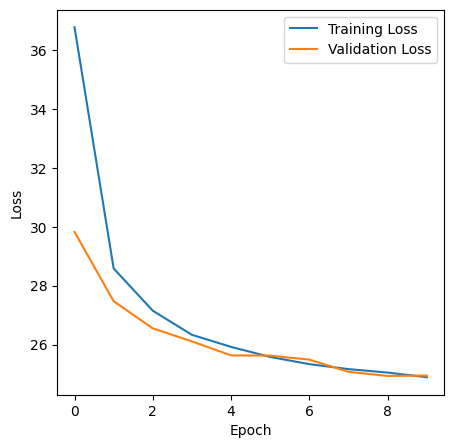

100%|██████████| 10/10 [03:53<00:00, 23.36s/it]

Epoch 10, Training Loss: 24.8945, Validation Loss: 24.9503


In [15]:
# Initialize model and optimizer
set_seed(42)
latent_size = 32
model = ConvVAE(input_channels=1, latent_size=latent_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = ELBO(beta=1)

# Training loop
train_losses, valid_losses = [], []
for epoch in tqdm(range(10)):
  train_loss = train(model, train_loader, criterion, optimizer, device)
  val_loss = validate(model, valid_loader, criterion, device)

  train_losses.append(train_loss)
  valid_losses.append(val_loss)

  # Clear and update plot
  clear_output(wait=True)
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.plot(train_losses, label='Training Loss')
  ax.plot(valid_losses, label='Validation Loss')
  ax.legend()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  plt.show()

  print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

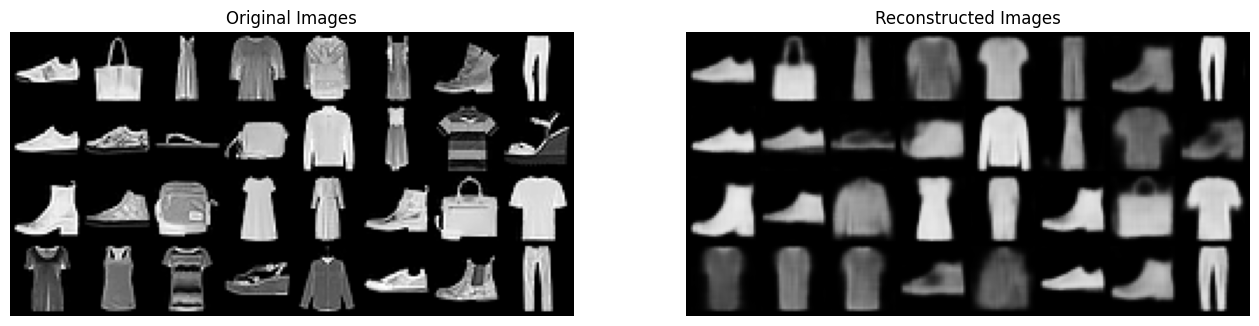

In [17]:
batch, labels = next(iter(valid_loader))  # Get the first batch of validation

model.eval()
with torch.no_grad():
    recon, _, _ = model(batch.to(device))

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plot_batch(batch[:32], nrow=8, title="Original Images", ax=axs[0])
plot_batch(recon[:32], nrow=8, title="Reconstructed Images", ax=axs[1])
plt.show()

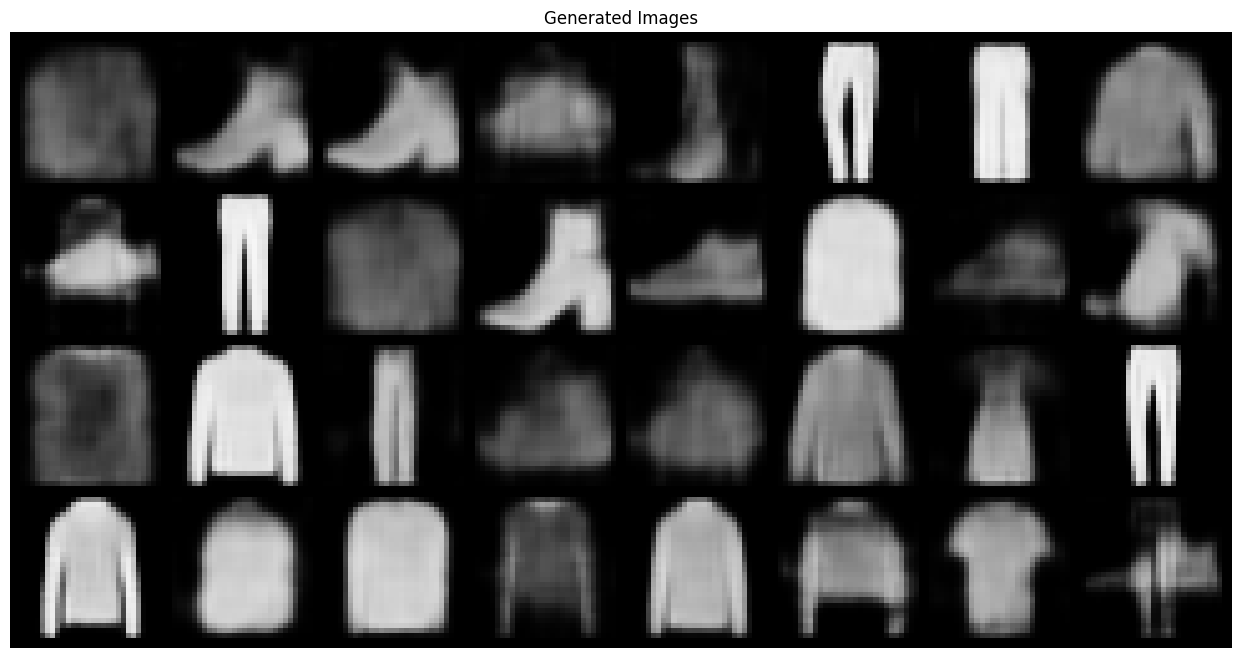

In [18]:
gen_z = torch.randn(32, latent_size).to(device)
with torch.no_grad():
    gen_images = model.decoder(gen_z)

plot_batch(gen_images, nrow=8, title="Generated Images")

## 5. Expanding our ConVAE with Class-Conditioning

In a conditional VAE, additional information such as class labels is incorporated into the model so that both the encoder and decoder operate with awareness of the conditioning variable. This is usually achieved by concatenating the label (or a learned embedding of it) to the encoder input and the latent vector, or by injecting the conditioning value directly into these inputs so that the latent space becomes class-aware during training. For this task, we will implement conditioning via addition. This means that we will “add” the value of our label to our input. But before we do that, we must project the one-hot labels through a linear layer so that they lie in the same dimensional space as the corresponding input: one projection matching the spatial dimensions of the encoder input, and another matching the dimensionality of the latent space so that conditioning can also be applied within the decoder. One fun outcome of this is that our model is also learning the "best" projection during optimisation!


Tasks


- Write a function that converts a batch of integer class labels into one-hot vectors of dimension 10, ensuring the tensor is created on the same device as the labels.

- Rewrite the convolutional encoder and decoder from the previous task so that each includes a linear layer mapping a one-hot vector of 10 classes to the appropriate dimension $1\times 28\times 28$ for the encoder input and the latent size for the decoder. Then add these embeddings to the inputs before forwarding through the network and adjust your final convolutional VAE accordingly. In this step, you may find it easier and more succinct to *inherit* from your previously implemented classes.

- Adjust your `train` and `validate` functions accordingly to use those class labels.

- Train your conditional VAE with the same hyperparameters from Question #4

- Generate 10 samples for each class by drawing random latent vectors, assigning a fixed label to each group, decoding them with the conditioned decoder, and plotting a row of images per label to inspect how well the model controls class-specific generation.

In [29]:
def one_hot_batch(labels, num_classes=10):
    """Convert a batch of labels to one-hot encoding."""
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes).to(labels.device)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

class ConvEncoderConditioned(ConvEncoder):
    def __init__(self, input_channels: int, latent_size: int = 16):
        super().__init__(input_channels, latent_size)

        # Trainable embedding layer for labels
        # that is added to the input image
        # each label (0-9) is mapped to a vector of size 1*28*28
        self.label_emb = nn.Linear(10, 1*28*28)

    def forward(self, x, labels):
        # Add label embedding to input image
        labels = one_hot_batch(labels, num_classes=10)
        x = x + self.label_emb(labels).view(-1, 1, 28, 28)
        return super().forward(x)


class ConvDecoderConditioned(ConvDecoder):
    def __init__(self, input_channels: int, latent_size: int = 16):
        super().__init__(input_channels, latent_size)

        # Trainable embedding layer for labels
        # that is added to the latent vector
        self.label_emb = nn.Linear(10, latent_size)

    def forward(self, z, labels):
        labels = one_hot_batch(labels, num_classes=10)
        label_embeddings = self.label_emb(labels)
        z = z + label_embeddings
        return super().forward(z)


class ConvVAEConditioned(ConvVAE):
    def __init__(self, input_channels: int, latent_size: int = 16):
        super().__init__(input_channels, latent_size)
        self.encoder = ConvEncoderConditioned(input_channels, latent_size)
        self.decoder = ConvDecoderConditioned(input_channels, latent_size)

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.sample(mu, logvar)
        return self.decoder(z, labels), mu, logvar


In [30]:
def train_conditioned(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        recon, mu, logvar = model(data, labels)

        loss = criterion(recon, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    return avg_loss

def validate_conditioned(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)
            recon, mu, logvar = model(data, labels)

            loss = criterion(recon, data, mu, logvar)
            val_loss += loss.item()

    avg_loss = val_loss / len(val_loader.dataset)
    return avg_loss

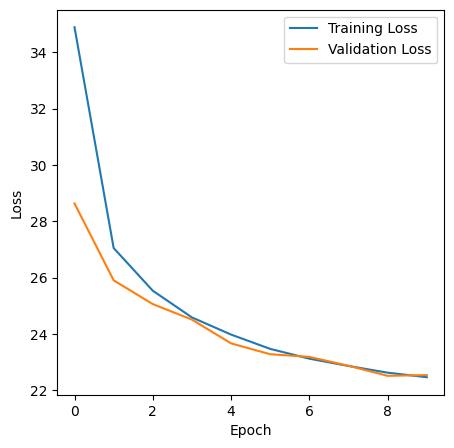

100%|██████████| 10/10 [04:03<00:00, 24.36s/it]

Epoch 10, Training Loss: 22.4637, Validation Loss: 22.5402


In [31]:
# Initialize model and optimizer
set_seed(42)
latent_size = 32
model = ConvVAEConditioned(input_channels=1, latent_size=latent_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
kl_weight = 1.

# # Reconstruction loss
criterion = ELBO(beta=kl_weight)

# Training loop
train_losses, valid_losses = [], []
for epoch in tqdm(range(10)):
    train_loss = train_conditioned(model, train_loader, criterion, optimizer, device)
    valid_loss = validate_conditioned(model, valid_loader, criterion, device)

    # Store losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Clear and update plot
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(valid_losses, label='Validation Loss')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.show()

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

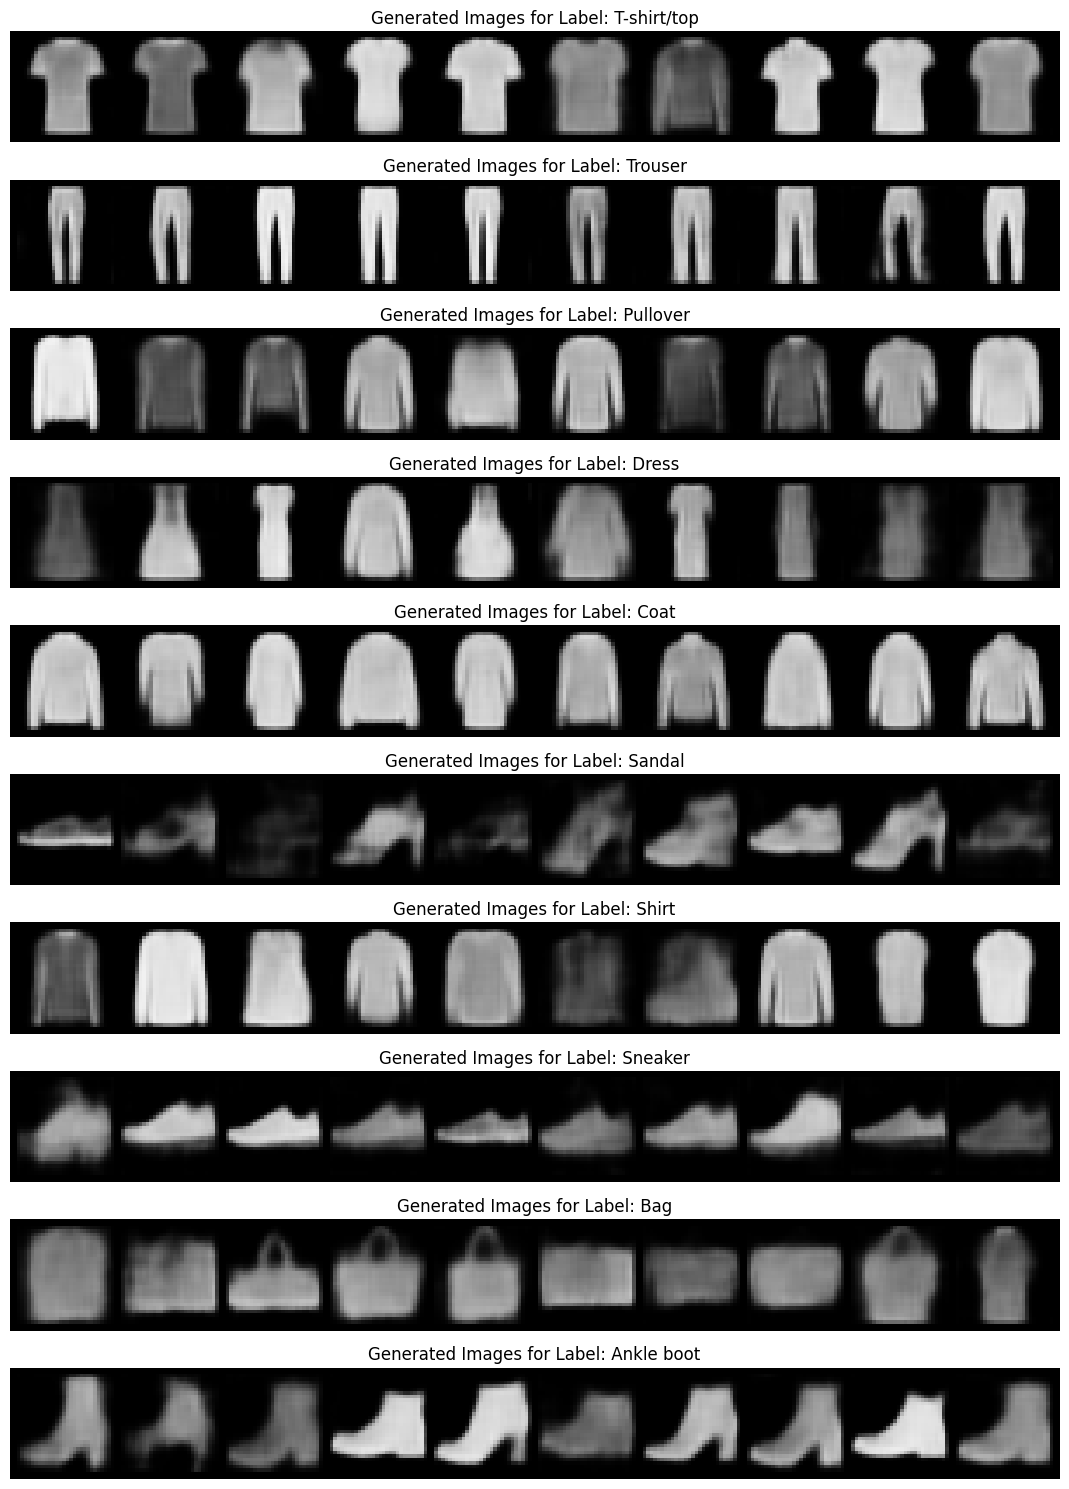

In [32]:
fig, axs = plt.subplots(10, 1, figsize=(15, 15))
with torch.no_grad():
    for label in range(10):
        gen_z = torch.randn(10, latent_size).to(device)
        labels = torch.full((10,), label, dtype=torch.long).to(device)
        gen_x = model.decoder(gen_z, labels)
        class_name = dataset.classes[label]
        plot_batch(gen_x, nrow=10, title=f"Generated Images for Label: {class_name}", ax=axs[label])
plt.tight_layout()
plt.show()